In [1]:
%pylab inline --no-import-all
import george
from george.kernels import MyDijetKernelSimp


import math
import time
import numpy as np
import scipy.stats as ss
import scipy.special as ssp
import scipy.optimize as op
from iminuit import Minuit
import emcee

#import ROOT as r
#import warnings
#from rootpy.plotting import Hist, Hist2D, Legend, Canvas
#import rootpy.plotting.root2matplotlib as rplt

Populating the interactive namespace from numpy and matplotlib


In [2]:
xvalO = np.load("../GP_Paper/xvalO.npy")
yvalO = np.load("../GP_Paper/yvalO.npy")
xerrO = np.load("../GP_Paper/xerrO.npy")
xlowO = np.load("../GP_Paper/xlowO.npy")
xval = np.load("../GP_Paper/xval.npy")
yval = np.load("../GP_Paper/yval.npy")
xerr = np.load("../GP_Paper/xerr.npy")
smoothGPFit = np.load("../GP_Paper/initialGPfit.npy")


xvalO2D = xvalO.reshape(-1,1)
yvalO2D = yvalO.reshape(-1,1)

In [3]:
# function to display covariance matrices

def plot_cov(X, C, K, stationary=True):
    K = K #+ 1e-8*np.eye(X.shape[0])
    x = X.flatten()
    
    fig = plt.figure(figsize=(14,5))
    ax1 = fig.add_subplot(131)
    m = ax1.imshow(C, cmap="inferno",
                   interpolation='none',
                   extent=(np.min(X), np.max(X), np.max(X), np.min(X)));
    plt.colorbar(m);
    ax1.set_title("Correlation Matrix")
    ax1.set_xlabel("X")
    ax1.set_ylabel("X")

    ax2 = fig.add_subplot(132)
    m = ax2.imshow(np.log(K), cmap="inferno",
                   interpolation='none',
                   extent=(np.min(X), np.max(X), np.max(X), np.min(X)));
    plt.colorbar(m);
    ax2.set_title("Log(Covariance Matrix)")
    ax2.set_xlabel("X")
    ax2.set_ylabel("X")
    
    ax3 = fig.add_subplot(133)
    m = ax3.imshow(K, cmap="inferno",
                   interpolation='none',
                   extent=(np.min(X), np.max(X), np.max(X), np.min(X)));
    plt.colorbar(m);
    ax3.set_title("Covariance Matrix")
    ax3.set_xlabel("X")
    ax3.set_ylabel("X")
    
    fig = plt.figure(figsize=(13,5))
    ax = fig.add_subplot(111)
    if not stationary:
        ax.plot(x, np.diag(K), "k", lw=2, alpha=0.8)
        #ax2.plot(x, 2e6*np.exp(-(x/300)), c='g')
        ax.set_title("The Diagonal of K")
        ax.set_ylabel("k(x,x)")
        ax.set_xscale('log')
        ax.set_yscale('log')
    else:
        ax.plot(x, K[:,0], "k", lw=2, alpha=0.8)
        ax.set_title("K as a function of x - x'")
        ax.set_ylabel("k(x,x')")
    ax.set_xlabel("X")

    '''
    fig = plt.figure(figsize=(14,4))
    ax = fig.add_subplot(111)
    samples = np.random.multivariate_normal(modelMatrix[0], K, 5).T;
    for i in range(samples.shape[1]):
        ax.plot(x, samples[:,i], color=cmap.inferno(i*0.2), lw=2);
    ax.set_title("Samples from GP Prior")
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel("X")
    '''


In [4]:

#background only plots
def makePrettyPlots(xs, ys, bkgs, title, col = 'g', ymax = 2e5):
    f, (ax1, ax2) = plt.subplots(2, sharex=True, figsize=(12,12), gridspec_kw = {'height_ratios':[3, 1]})
    f.suptitle(title, fontsize=30)
    dataPlot = ax1.errorbar(xs, ys, marker='o', ls='None', yerr = np.sqrt(ys), c='black', markersize=10, label="data+signal")
    bkgPlot, =ax1.plot(xs, bkgs, color=col, linewidth=3.0, label="bkg only")
    ax1.legend()
    ax1.set_ylabel('Events', fontsize=20)
    ax1.tick_params(axis='y', labelsize=20)
    ax1.set_yscale('log', nonposy="clip")
    ax1.set_xscale('log')
    ax1.set_xlim([1000, 7500])
    ax1.set_ylim([0.01, ymax])


  
    #bin by bin significance    
    zvals, chi2 = calcSignificance(ys, bkgs)
    print "chi2", chi2
    h1 = Hist(xlowO,markersize=0)
    for x in range(len(zvals)):
        if zvals[x] == np.inf or zvals[x] == -np.inf: h1[x] = 20
        else: h1[x] = zvals[x]  


    
    h1.fillstyle = 'solid'
    if col == 'g':
         h1.fillcolor = 'green'
    elif col == 'b':
         h1.fillcolor = 'blue'
    elif col == 'r':
         h1.fillcolor = 'red'
    else:
        h1.fillcolor = 'black'
    h1.linecolor = 'black'
    h1.linewidth = 1
    h1.Draw("histX0")
    rplt.bar(h1, xerr=None, yerr=None)
    ax2.axhline(0, color='black', lw=1)
    ax2.tick_params(axis='x', labelsize=20)
    ax2.tick_params(axis='y', labelsize=20)
    ax2.set_xlabel(r"$m_{jj}$ [TeV]", fontsize=30)
    ax2.set_ylabel('Significance', fontsize=20)
    ax2.set_xscale('log')
    ax2.set_xlim([1000, 7500])
    ax2.set_xticks([1000, 2000, 3000, 4000, 5000, 6000, 7000])
    ax2.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    minor_ticks = np.arange(1000, 7500, 100)
    ax2.set_xticks(minor_ticks, minor=True)  
    labels = ["1","2","3","4","5","6","7"]
    ax2.set_xticklabels(labels)
    ax2.set_ylim([-5, 5])
    
    f.subplots_adjust(hspace=0)
    plt.setp([a.get_xticklabels() for a in f.axes[:-1]], visible=False)    
    plt.show()

def calcSignificance(Data, Bkg):
    pvals = []
    zvals = []
    chi2 = 0
    for i, nD in enumerate(Data):
        nB = Bkg[i]
        if nD != 0:
            if nB > nD:
                #pval = 1.-r.TMath.Gamma(nD+1.,nB)
                pval = 1.-ssp.gammainc(nD+1.,nB)
            else:
                #pval = pval = r.TMath.Gamma(nD,nB)
                pval = ssp.gammainc(nD,nB)
            prob = 1.-2.*pval
            if prob > -1 and prob < 1:
                #zval = math.sqrt(2.)*r.TMath.ErfInverse(prob)
                zval = math.sqrt(2.)*ssp.erfinv(prob)
            else:
                zval = np.inf
                #print "crap"
            if zval > 100: zval = 20
            if zval < 0: zval = 0
            if (nD < nB): zval = -zval
           # print nD, nB, pval, prob, zval
        else: zval = 0
            
        zvals.append(zval)
        chi2 += ((nD - nB) ** 2 / abs(nB)) #/len(nB)
    return zvals, chi2

In [5]:
def logLike_ind(p):
    if p[0] < 0 or np.any(-20 > p[1:]) or np.any(p > 20):
        return -np.inf
    bkgFunc = model_3param(xvalO, p, xerrO)
    return -0.5 * np.sum( (bkgFunc-yvalO)*(bkgFunc-yvalO) / bkgFunc) 
    


def logLike_3ff_emcee(p):
    if p[0] < 0 or np.any(-20 > p[1:]) or np.any(p > 20):
        return -np.inf
    lnprior = 0.0
    bkgFunc = model_3param(xvalO, p, xerrO)       
    logL = 0
    for ibin in range(len(yvalO)):
        data = yvalO[ibin]
        bkg = bkgFunc[ibin]
        logL += -simpleLogPoisson(data, bkg)
    if not math.isnan(logL):
        return -logL
    else:
        return np.inf


def fit_3ff_emcee(p, lnprob):
    nwalkers, ndim = 36, len(p)
    p0 = [np.array(p) + 1e-8 * np.random.randn(ndim)
          for i in xrange(nwalkers)]
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob)

    print("Running first burn-in...")
    p0, lnp, _ = sampler.run_mcmc(p0, 500)
    p = p0[np.argmax(lnp)]
    sampler.reset()

    print("Running second burn-in")
    p = p0[np.argmax(lnp)]
    p0 = [p + 1e-8 * np.random.randn(ndim) for i in xrange(nwalkers)]
    p0, _, _ = sampler.run_mcmc(p0, 500)
    sampler.reset()

    print("Running production")
    p0, _, _ = sampler.run_mcmc(p0, 1000)
    return sampler

In [6]:
def model_gp(params, t, xerr=xerr): 
    #global xerr
    p0, p1, p2 = params
    sqrts = 13000.
    return (p0 * (1.-t/sqrts)**p1 * (t/sqrts)**(p2))*xerr

def fit_gp_minuit(lnprob, Print = True):
    #np.random.seed(1234)
    bestval = np.inf
    bestargs = (0, 0, 0, 0, 0, 0, 0, 0)
    #for i in range(num):
    passedFit = False
    numRetries = 0
    #while not passedFit and numRetries < 5:
    for num in range(100):
        init0 = np.random.random() * 1e7+1
        init1 = np.random.random() * 200.
        init2 = np.random.random() * 10. 
        init3 = np.random.random() * -100.
        init4 = np.random.random() * 6.
        init5 = np.random.random() * 1.
        init6 = np.random.random() * 1.
        init7 = np.random.random() * -1.
        m = Minuit(lnprob, throw_nan = False, pedantic = False, print_level = 0, errordef = 0.5,
                  Amp = init0, decay = init1, length = init2, power = init3, sub = init4, 
                   p0 = init5, p1 = init6, p2 = init7,
                  error_Amp = 1e1, error_decay = 1e1, error_length = 1e-1, error_power = 1e-1, 
                   error_sub = 1e-1, error_p0 = 1e-2, error_p1 = 1e-2, error_p2 = 1e-2,
                  limit_Amp = (1, 1e15), limit_decay = (0, 500), limit_length = (0, 200), 
                   limit_power = (-200, 200), limit_sub = (0, 100), limit_p0 = (0,10), 
                   limit_p1 = (0, 20), limit_p2 = (-10,10)) 
        fit = m.migrad()
        '''
        if fit[0]['is_valid']: 
            passedFit=True
            
        if numRetries == 4: 
            print "retry number = ", 5, ": failed fits"
            bestval=np.inf
            bestargs=(0, 0, 0, 0, 0, 0, 0, 0)
        numRetries+=1 
        '''

        if m.fval < bestval:
            bestval = m.fval
            bestargs = m.args     
            


    if Print:
        print "min LL",bestval
        print "best fit vals", bestargs
    return bestval, bestargs


class logLike_gp_minuit:
    def __init__(self, x, y, xerr):
        self.x = x
        self.y = y
        self.xerr = xerr
    def __call__(self, Amp, decay, length, power, sub, p0, p1, p2):
        kernel = Amp * MyDijetKernelSimp(a = decay, b = length, c = power, d = sub)
        gp = george.GP(kernel)
        try:
            gp.compute(self.x, np.sqrt(self.y))
            return -gp.lnlikelihood(self.y - model_gp((p0,p1,p2), self.x, self.xerr))
        except:
            return np.inf

In [7]:
def model_3param(t, params, xErr=xerr): 
    p0, p1, p2 = params
    sqrts = 13000.
    return (p0 * ((1.-t/sqrts)**p1) * (t/sqrts)**(p2))*(xErr)  

def simpleLogPoisson(x, par):
    if x < 0: 
        #print "crap"
        return np.inf
    elif (x == 0): return -1.*par
    else:
        #lnpoisson = x*np.log(par)-par-r.TMath.LnGamma(x+1.)
        lnpoisson = x*np.log(par)-par-ssp.gammaln(x+1.)
        return lnpoisson

In [8]:
class logLike_3ff_minuit:
    def __init__(self, x, y, xe):
        self.x = x
        self.y = y
        self.xe = xe
    def __call__(self, p0, p1, p2):
        params = p0, p1, p2
        bkgFunc = model_3param(self.x, params, self.xe)       
        logL = 0
        for ibin in range(len(self.y)):
            data = self.y[ibin]
            bkg = bkgFunc[ibin]
            logL += -simpleLogPoisson(data, bkg)
        try:
            logL
            return logL
        except:
            return np.inf
def fit_3ff_minuit(num,lnprob):
  #  np.random.seed(1234)
    bestval = np.inf
    bestargs = (0., 0., 0.)
    for i in range(num):
        init0 = np.random.random() * 1.
        init1 = np.random.random() * 8.
        init2 = np.random.random() * 6.
        m = Minuit(lnprob, throw_nan = False, pedantic = False, print_level = 0,
                  p0 = init0, p1 = init1, p2 = init2,
                  error_p0 = 1e-2, error_p1 = 1e-1, error_p2 = 1e-1, 
                  limit_p0 = (0, 100.), limit_p1 = (-100., 100.), limit_p2 = (-100., 100.))
        m.migrad()
        if m.fval < bestval:
            bestval = m.fval
            bestargs = m.args 
    # if Print:
    #     print "min LL",bestval
    #     print "best fit vals", bestargs
    return bestval, bestargs

In [9]:
def basicPlot(xs, ys, bkgs, title, col='g'):
    f, (ax1) = plt.subplots(1, sharex=True, figsize=(12,12))
    f.suptitle(title, fontsize=30)
    dataPlot = ax1.errorbar(xs, ys, marker='o', ls='None', yerr = np.sqrt(ys), c='black', markersize=10, label="QCD MC")
    bkgPlot, = ax1.plot(xs, bkgs, color=col, linewidth=3.0, label="GP fit")
    ax1.legend()
    ax1.set_ylabel('Events', fontsize=20)
    ax1.tick_params(axis='y', labelsize=20)
    ax1.set_yscale('log', nonposy="clip")
    ax1.set_xscale('log')
    ax1.set_xlim([1000, 7500])
    ax1.set_ylim([0.01, 2e6])

### Fitting smooth distribution or smeared distribution

#### 3 param on atlas data

In [10]:
lnProb = logLike_3ff_minuit(xvalO,yvalO,xerrO)
bestval, best_fit_new = fit_3ff_minuit(100, lnProb)
bkg3param = model_3param(xvalO, best_fit_new, xerrO)
asimov = model_3param(xvalO, best_fit_new, xerrO)

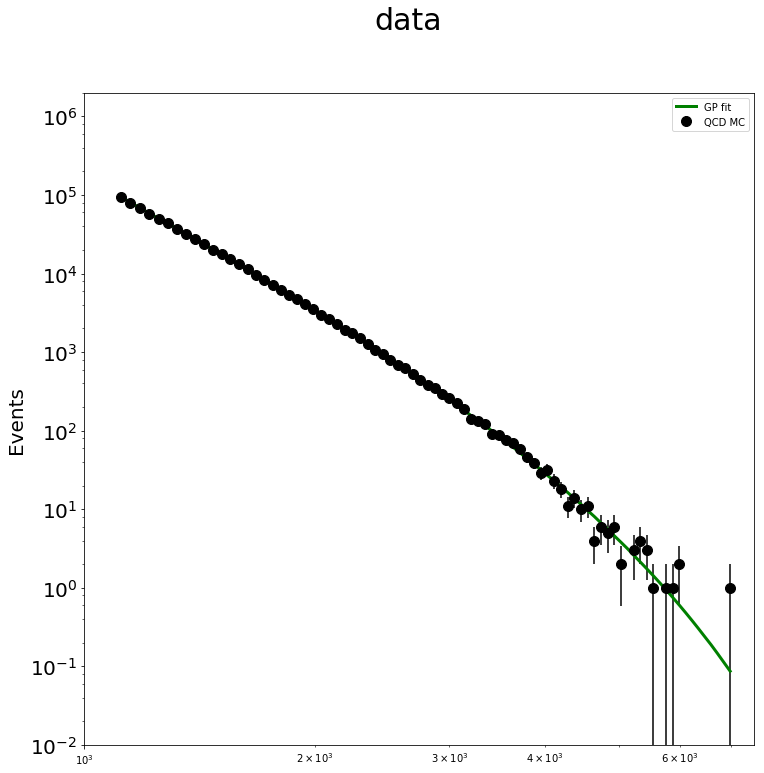

In [11]:
basicPlot(xvalO, yvalO, asimov, "data")

In [12]:
#makePrettyPlots(xvalO, yvalO, asimov, "3 param on ATLAS data")

In [13]:
p=[1., 1.0, -5.]
samples = fit_3ff_emcee(p, logLike_ind)

pvalues = samples.flatchain
#print sampleset
print pvalues.shape
print pvalues.mean(axis=0)

modelMatrix=np.empty([pvalues.shape[0], xvalO.size])
for ip, ps in enumerate(pvalues):
    bkg = model_3param(xvalO, ps, xErr=xerrO)
    modelMatrix[ip,:]= bkg
covMat = np.cov(modelMatrix.T)
corMat = np.corrcoef(modelMatrix.T)

Running first burn-in...
Running second burn-in
Running production
(36000, 3)
[ 0.01708498  8.46321367 -5.21899078]


/Users/Darren/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in log


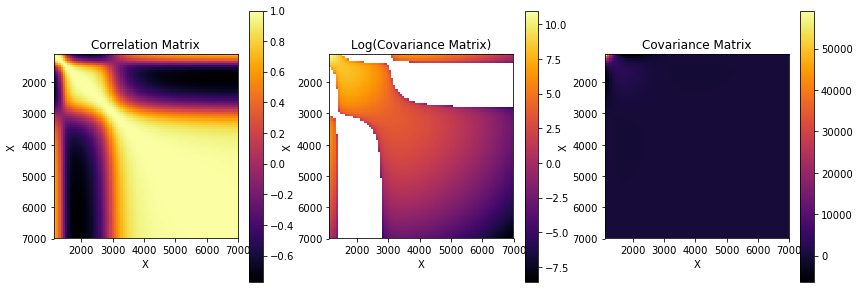

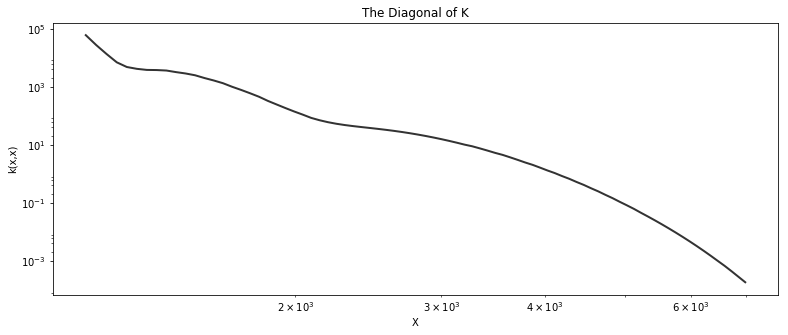

In [14]:
plot_cov(xvalO2D, corMat, covMat, False)
#makePrettyPlots_bkgFits(xvalO, xvalO, yvalO, (modelMatrix3p[:100]).tolist(), "", ymax = 2e5)

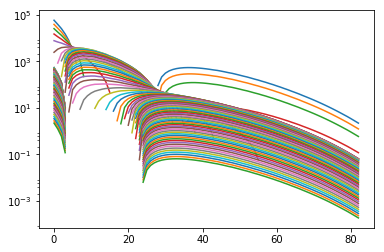

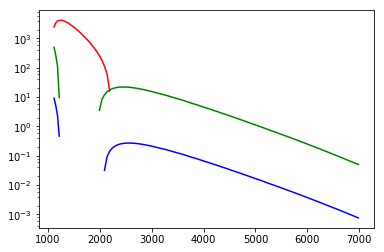

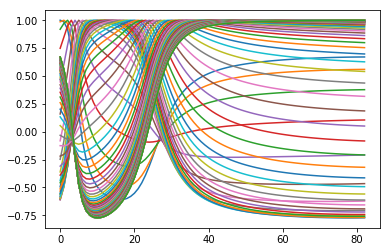

In [15]:
for i in range(len(covMat[1])):
    plt.plot(np.arange(len(covMat[1])),(covMat[i,:]))
plt.semilogy()
plt.figure()
plt.semilogy()
plt.plot(xvalO,(covMat[5,:]), c='r')
plt.plot(xvalO,(covMat[40,:]), c='g')
plt.plot(xvalO,(covMat[75,:]),c='b')
plt.figure()
for i in range(len(corMat[1])):
    plt.plot(np.arange(len(corMat[1])),(corMat[i,:]))

#### 3 param on smooth data

In [16]:
lnProb = logLike_3ff_minuit(xvalO, asimov ,xerrO)
bestval, best_fit_new = fit_3ff_minuit(100, lnProb)
smoothPs = best_fit_new
#background with best fit parameters
bkg3param = model_3param(xvalO, best_fit_new, xerrO)

#makePrettyPlots(xvalO, asimov, bkg3param, "3 param on smooth data")

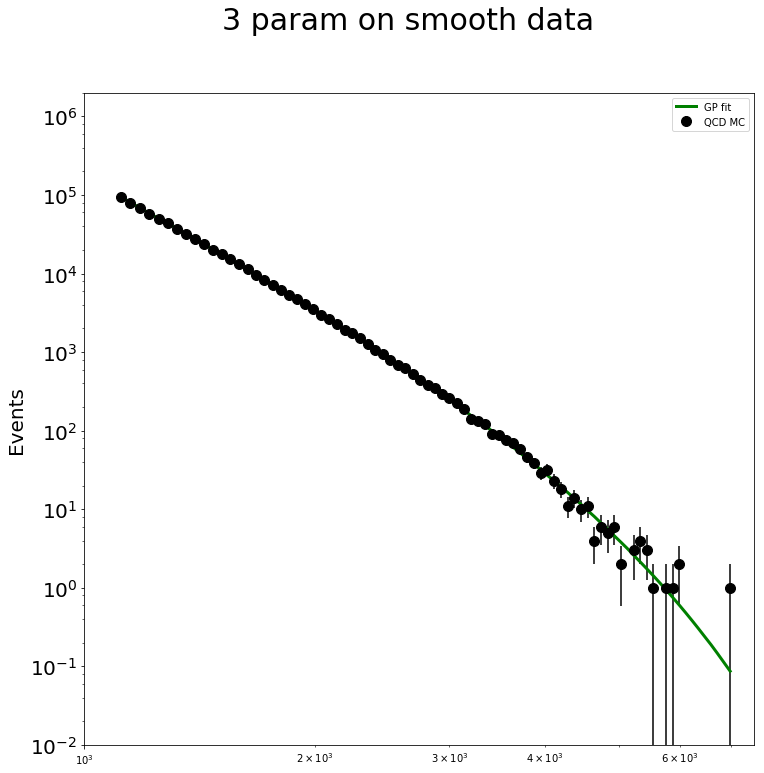

In [17]:
basicPlot(xvalO, yvalO, bkg3param, "3 param on smooth data")

In [18]:
def logLike_ind_smooth(p):
    if p[0] < 0 or np.any(-20 > p[1:]) or np.any(p > 20):
        return -np.inf
    bkgFunc = model_3param(xvalO, p, xerrO)
    return -0.5 * np.sum( (bkgFunc-asimov)*(bkgFunc-asimov) / bkgFunc) 

In [19]:
p=[1., 1.0, -5.]
samples = fit_3ff_emcee(p, logLike_ind_smooth)

pvalues = samples.flatchain
#print sampleset
print pvalues.shape
print pvalues.mean(axis=0)

modelMatrix=np.empty([pvalues.shape[0], xvalO.size])
for ip, ps in enumerate(pvalues):
    bkg = model_3param(xvalO, ps, xErr=xerrO)
    modelMatrix[ip,:]= bkg
covMat = np.cov(modelMatrix.T)
corMat = np.corrcoef(modelMatrix.T)

Running first burn-in...
Running second burn-in
Running production
(36000, 3)
[ 0.02605945  9.26228344 -5.10549468]


/Users/Darren/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in log


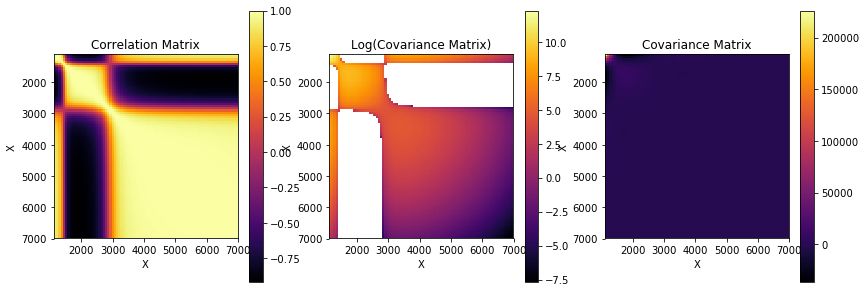

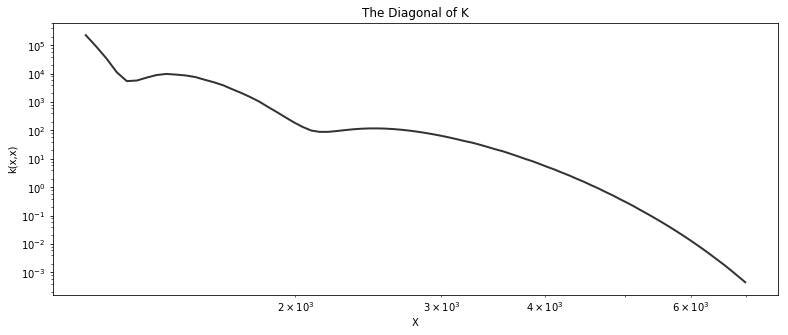

In [ ]:
plot_cov(xvalO2D, corMat, covMat, False)

#### GP on atlas data

In [ ]:
lnProb = logLike_gp_minuit(xval,yval, xerr)
bestval, hyperpso = fit_gp_minuit(lnProb)
Amp, decay, length, power, sub, p0, p1, p2 = hyperpso
kernel = Amp * MyDijetKernelSimp(a = decay, b = length, c = power, d=sub)
gp = george.GP(kernel)
gp.compute(xval, np.sqrt(yval))
meanGPp, covGP = gp.predict(yval - model_gp(hyperpso[5:],xval, xerr), xvalO)
meanGP = meanGPp+ model_3param(xvalO,hyperpso[5:],xerrO)

In [ ]:
#makePrettyPlots(xvalO, yvalO, meanGP, "GP on ATLAS data")
basicPlot(xvalO, yvalO, meanGP, "GP on ATLAS data")

In [ ]:
samps = gp.sample_conditional(yval - model_gp(hyperpso[5:],xval, xerr), xvalO, 1000)
print samps.shape
modelMatrix=np.empty([samps.shape[0], xvalO.size])
print modelMatrix.shape
for ip, ps in enumerate(samps):
    modelMatrix[ip,:]= samps[ip,:]+ model_3param(xvalO,hyperpso[5:],xerrO)
covMat = np.cov(modelMatrix.T)
corMat = np.corrcoef(modelMatrix.T)

In [ ]:
plot_cov(xvalO2D, corMat, covMat, False)
#makePrettyPlots_bkgFits(xvalO, xvalO, yvalO, (modelMatrixgp[:100]).tolist(), "", ymax = 2e5)

In [ ]:
for i in range(len(covMat[1])):
    plt.plot(np.arange(len(covMat[1])),(covMat[i,:]))
plt.semilogy()
plt.figure()
plt.semilogy()
plt.plot(xvalO,(covMat[5,:]), c='r')
plt.plot(xvalO,(covMat[40,:]), c='g')
plt.plot(xvalO,(covMat[75,:]),c='b')
plt.figure()
for i in range(len(corMat[1])):
    plt.plot(np.arange(len(corMat[1])),(corMat[i,:]))

#### GP on smooth data

In [ ]:
lnProb = logLike_gp_minuit(xvalO,asimov, xerrO)
bestval, hyperps = fit_gp_minuit(100, lnProb)
Amp, decay, length, power, sub, p0, p1, p2 = hyperps
kernel = Amp * MyDijetKernelSimp(a = decay, b = length, c = power, d=sub)
gp = george.GP(kernel)
gp.compute(xvalO, np.sqrt(asimov))
meanGPp, covGP = gp.predict(asimov - model_gp(hyperps[5:],xvalO, xerrO), xvalO)
meanGP = meanGPp+ model_3param(xvalO,hyperps[5:],xerrO)

In [ ]:
basicPlot(xvalO, asimov, meanGP, "GP on smooth data")
#makePrettyPlots(xvalO, asimov, meanGPnom, "GP on smooth data")

In [ ]:
samps = gp.sample_conditional(asimov - model_gp(hyperps[5:],xvalO, xerrO), xvalO, 1000)
print samps.shape
modelMatrix=np.empty([samps.shape[0], xvalO.size])
print modelMatrix.shape
for ip, ps in enumerate(samps):
    modelMatrix[ip,:]= samps[ip,:]+ model_3param(xvalO,hyperps[5:],xerrO)
covMat = np.cov(modelMatrix.T)
corMat = np.corrcoef(modelMatrix.T)

In [ ]:
plot_cov(xvalO2D, corMat, covMat, False)